In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from kaggle_prediction_interval_birthweight.model.sampling_utils import (
    compute_highest_density_interval,
)
from kaggle_prediction_interval_birthweight.workflow.metric import score
from kaggle_prediction_interval_birthweight.data.data_processing import DataProcessor

In [3]:
data = pd.read_csv("../data/train.csv")

In [4]:
train_processor = DataProcessor(model_type="xgboost")

In [5]:
X, y = train_processor(data)

In [6]:
np.isnan(X).any()

False

In [7]:
print(X.shape)

(108082, 86)


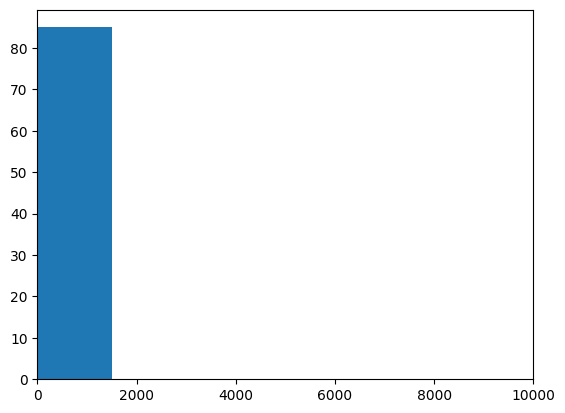

In [16]:
plt.hist(np.nanmean(X, axis=0), bins=30)
plt.xlim(0, 10000)
plt.show()

In [11]:
X.max()

9999999.0

Coverage is 90.0%


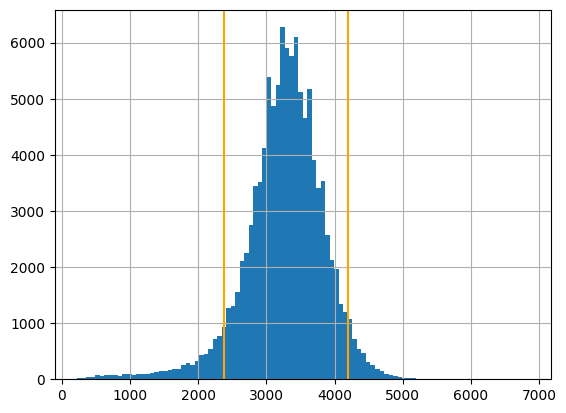

In [9]:
lower, upper = compute_highest_density_interval(data["DBWT"])

print(f"Coverage is {data['DBWT'].between(lower, upper).mean() * 100:.1f}%")

data["DBWT"].hist(bins=100)
plt.axvline(lower, color="orange")
plt.axvline(upper, color="orange")
plt.show()

In [10]:
nois, coverage = score(data["DBWT"].values, lower, upper, 0.9)

print(f"NOIS is {nois:.1f}, and coverage is {coverage*100:.1f}%")

NOIS is 1904.4, and coverage is 90.0%
